In [1]:
from lake_model_outputspace_exploration import lake_problem

from ema_workbench import (
    Model,
    RealParameter,
    ScalarOutcome,
    Constant,
    ema_logging,
    MultiprocessingEvaluator,
    Policy,
    SequentialEvaluator,
    OutputSpaceExploration
)

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# instantiate the model
lake_model = Model("lakeproblem", function=lake_problem)
lake_model.time_horizon = 100

# specify uncertainties
lake_model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers, one for each time step
lake_model.levers = [
    RealParameter(str(i), 0, 0.1) for i in range(lake_model.time_horizon)
]

# specify outcomes
# TODO kind argument can be ignored when doing
# output space exploration

lake_model.outcomes = [
    ScalarOutcome("max_P", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("utility", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", kind=ScalarOutcome.MAXIMIZE),
]

# override some of the defaults of the model
lake_model.constants = [Constant("alpha", 0.41), Constant("nsamples", 150)]

# generate some random policies by sampling over levers
n_scenarios = 1000
reference = Policy('nopolicy', **{l.name:0.02 for l in lake_model.levers})



# output space exploration

Output space exploration is a form of optimization based on novelty search. In the workbench, it relies on the optimization functionality. You can use output space exploration by passing an instance of either `OutputSpaceExploration` or `AutoAdaptiveOutputSpaceExploration` as algorithm to `evaluator.optimize`. The fact that output space exploration uses the optimization functionality also implies that we can track convergence in a similar manner. Epsilon progress is defined identical, but evidently other metrics such as hypervolume might not be applicable in the context of output space exploration.

The difference between `OutputSpaceExploration` and `AutoAdaptiveOutputSpaceExploration` is in the evolutionary operators. `AutoAdaptiveOutputSpaceExploration` uses auto adaptive operator selection as implemented in the BORG MOEA, while `OutputSpaceExploration` by default uses Simulated Binary crossover with polynomial mutation. Injection of new solutions is handled through auto adaptive population sizing and periodically starting with a new population if search is stalling. Below, examples are given of how to use both algorithms, as well as a a quick visualization of the convergence dynamics.

In [3]:
from ema_workbench.em_framework.optimization import EpsilonProgress

convergences = []

with MultiprocessingEvaluator(lake_model) as evaluator:
    for _ in range(5):
        convergence_metrics = [
            EpsilonProgress(),
        ]        
        res, convergence = evaluator.optimize(algorithm=OutputSpaceExploration,
                                 grid_spec=[(0, 12, 0.5),
                                            (0, 0.6, 0.05),
                                            (0, 1, 0.1),
                                            (0, 1, 0.1)],
                                 nfe=25000,
                                 searchover='uncertainties',
                                 reference=reference,
                                 convergence=convergence_metrics)
        convergences.append(convergence)
    

[MainProcess/INFO] pool started with 10 workers
28085it [01:47, 260.33it/s]                                                    
[MainProcess/INFO] optimization completed, found 1397 solutions
27911it [01:47, 259.30it/s]                                                    
[MainProcess/INFO] optimization completed, found 1366 solutions
26973it [01:46, 253.63it/s]                                                    
[MainProcess/INFO] optimization completed, found 1375 solutions
28324it [01:48, 260.61it/s]                                                    
[MainProcess/INFO] optimization completed, found 1403 solutions
28749it [01:50, 259.12it/s]                                                    
[MainProcess/INFO] optimization completed, found 1420 solutions
[MainProcess/INFO] terminating pool


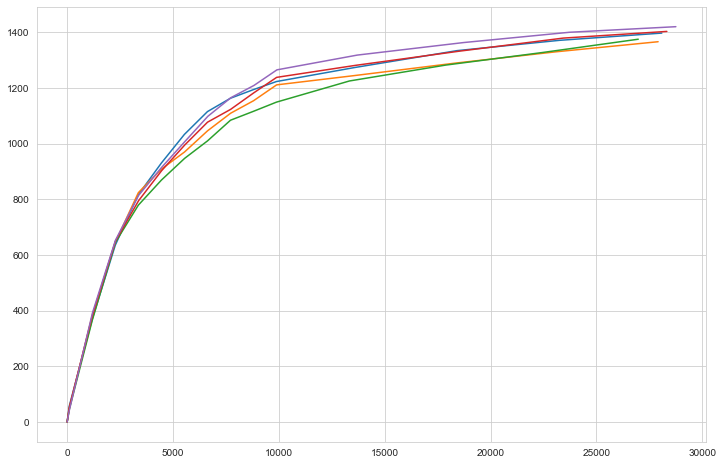

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, ax = plt.subplots()
for convergence in convergences:
    ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

In [6]:
from ema_workbench.em_framework.outputspace_exploration import AutoAdaptiveOutputSpaceExploration
from ema_workbench.em_framework.optimization import OperatorProbabilities


convergences = []

with MultiprocessingEvaluator(lake_model) as evaluator:
    
    for _ in range(5):
        convergence_metrics = [
            EpsilonProgress(),
            OperatorProbabilities("SBX", 0),
            OperatorProbabilities("PCX", 1),
            OperatorProbabilities("DE", 2),
            OperatorProbabilities("UNDX", 3),    
            OperatorProbabilities("SPX", 4),    
            OperatorProbabilities("UM", 5),    
        ]    
        res, convergence = evaluator.optimize(algorithm=AutoAdaptiveOutputSpaceExploration,
                                 grid_spec=[(0, 12, 0.5),
                                            (0, 0.6, 0.05),
                                            (0, 1, 0.1),
                                            (0, 1, 0.1)],
                                 nfe=25000,
                                 searchover='uncertainties',
                                 reference=reference,
                                 variator=None,
                                 convergence=convergence_metrics)
        convergences.append(convergence)
    

[MainProcess/INFO] pool started with 10 workers
29862it [02:00, 248.04it/s]                                                    
[MainProcess/INFO] optimization completed, found 1447 solutions
30350it [02:04, 243.65it/s]                                                    
[MainProcess/INFO] optimization completed, found 1454 solutions
29654it [02:02, 242.66it/s]                                                    
[MainProcess/INFO] optimization completed, found 1436 solutions
29724it [02:00, 246.71it/s]                                                    
[MainProcess/INFO] optimization completed, found 1437 solutions
30418it [02:02, 248.97it/s]                                                    
[MainProcess/INFO] optimization completed, found 1462 solutions
[MainProcess/INFO] terminating pool


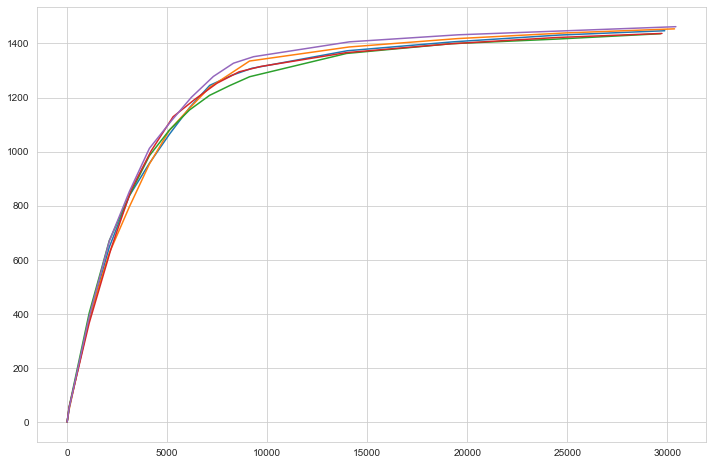

In [7]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
for convergence in convergences:
    ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

In case of `AutoAdaptiveOutputSpaceExploration` it can sometimes also be revealing to check the dynamics of the operators over the evolution. This is shown below separately for each seed. 

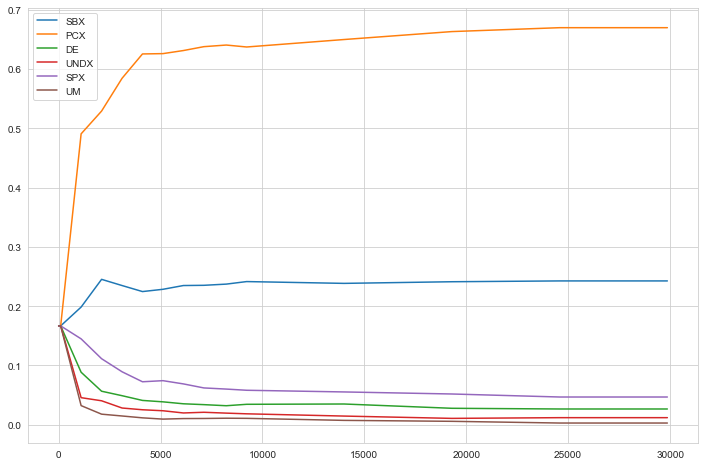

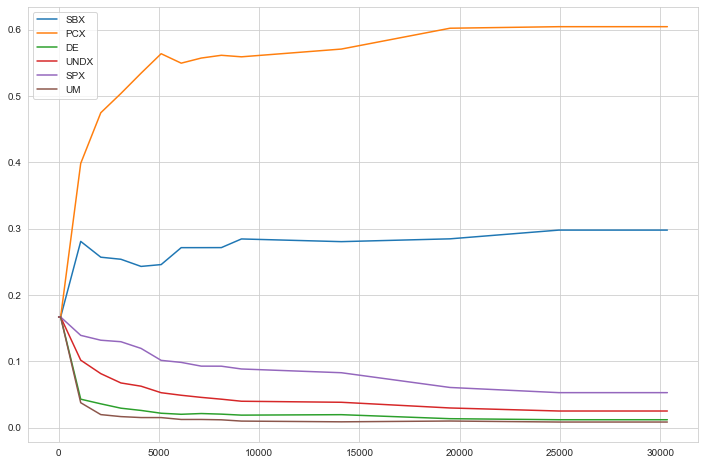

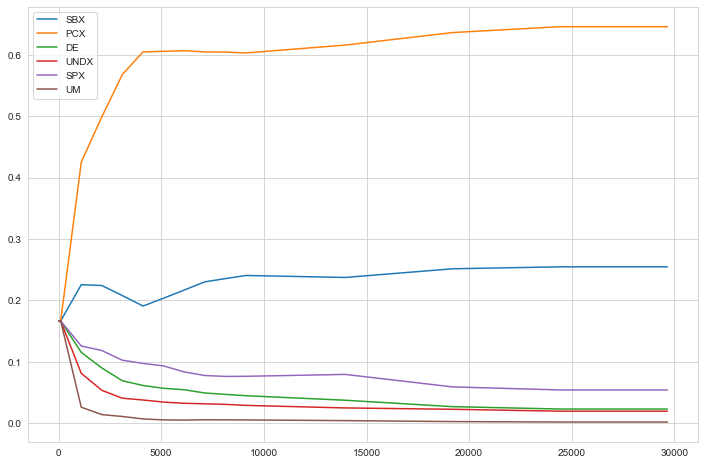

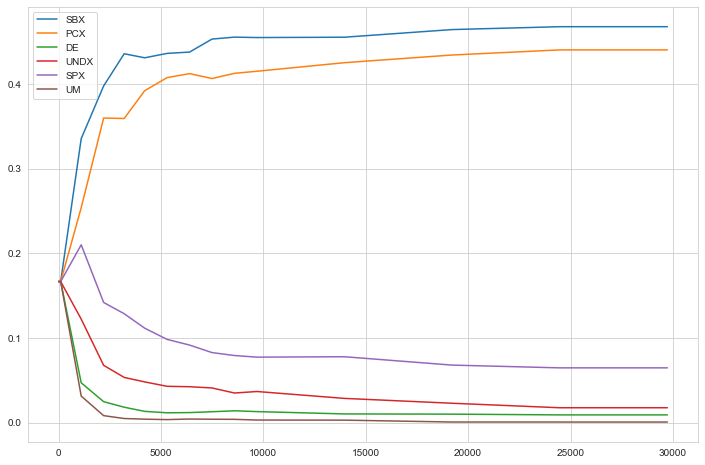

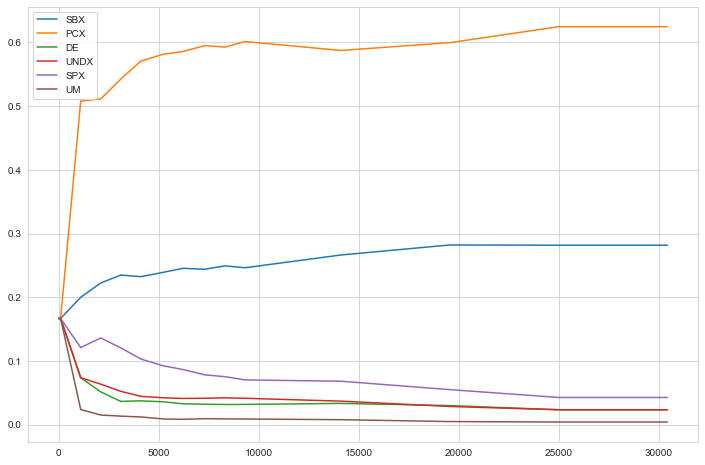

In [8]:
for convergence in convergences:
    fig, ax = plt.subplots()    
    ax.plot(convergence.nfe, convergence.SBX, label='SBX')
    ax.plot(convergence.nfe, convergence.PCX, label='PCX')
    ax.plot(convergence.nfe, convergence.DE, label='DE')
    ax.plot(convergence.nfe, convergence.UNDX, label='UNDX')
    ax.plot(convergence.nfe, convergence.SPX, label='SPX')
    ax.plot(convergence.nfe, convergence.UM, label='UM')
    ax.legend()
plt.show()

# LHS

for comparison, let's also generate an LHS and compare the results

In [9]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(
                             scenarios=1500,
                             policies=reference)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1500 scenarios * 1 policies * 1 model(s) = 1500 experiments
100%|█████████████████████████████████████| 1500/1500 [00:05<00:00, 289.77it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


# comparison
Below we compare the LHS with the last seed of the autoadaptive algorithm.

In [10]:
outcomes = pd.DataFrame(outcomes)
outcomes['sampling'] = 'LHS'

In [11]:
ose = res.iloc[:, 5::].copy()
ose['sampling'] = 'OSE'

In [12]:
data = pd.concat([ose, outcomes], axis=0,ignore_index=True)

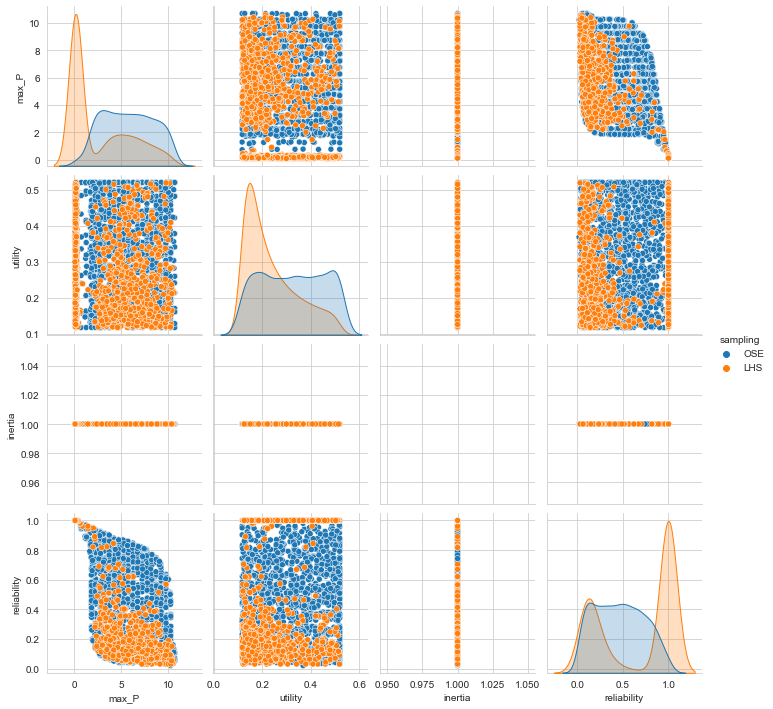

In [13]:
# sns.pairplot(data, hue='sampling')
sns.pairplot(data, hue='sampling', vars=data.columns[0:4])
plt.show()